In [58]:
import sys
sys.path.append('../_amigocloud')

In [59]:
import simplekml

In [60]:
from amigocloud import AmigoCloud
import pandas as pd
from shapely import wkb

import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
#from shapely.geometry import Point, MultiPoint
import os
#from fastkml import kml

In [61]:
# ruta de carpera donde estan las llaves
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]

In [62]:
# leer token
acceso = open(ruta + '/_keys/api_amigocloud.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

In [63]:
# leer los dos shps de siembra y puntos de planificacion
path_siembras = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\SIEMBRAS.shp'
path_cat = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\catastro140624.shp'
path_puntos = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\PUNTOS_PLAN.shp'

path_plan = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\PLANIFICACION_TEST.shp'

path_kml = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\KML_PLAN'

path_xlsx_parte = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\PARTE DIARIO TRICHOGRAMMA 2024_RES.xlsx'

# ACTUALIZAR SHP PLANIFICACION

In [122]:
ors = 33

In [123]:
gdf_siembras = gpd.read_file(path_siembras)
gdf_puntos = gpd.read_file(path_puntos)
gdf_cat = gpd.read_file(path_cat)

In [124]:
# verifica si ambos shps tienen el mismo CRS
if gdf_siembras.crs == gdf_puntos.crs:
    print('Ambas capas tienen el mismo CRS')
else:
    print('No tienen el mismo CRS')

Ambas capas tienen el mismo CRS


In [125]:
# filtrar la semana de interes
gdf_puntos_select = gdf_puntos[gdf_puntos['os'] == ors]
gdf_puntos_sem = gdf_puntos_select.copy()
#quita caracteres especiales
gdf_puntos_sem['unidad_04'] = gdf_puntos_sem['unidad_04'].str.replace(r'[\r\n\t]', '', regex=True)
gdf_puntos_sem

,unidad_03,unidad_04,os,dia,obs,procesado,geometry
12,1530,C.I.T.T.C.A,33,0,None,None,"MULTIPOINT (480204.614 8093487.788, 480035.631..."


In [126]:
multipoint_gdf = gdf_puntos_sem

In [127]:
# Crear una lista para almacenar los nuevos registros de puntos individuales
point_records = []
# Iterar sobre cada registro en el GeoDataFrame original
for idx, row in multipoint_gdf.iterrows():
    multipoint_geom = row.geometry
    # Verificar si la geometría es de tipo multipunto
    if isinstance(multipoint_geom, MultiPoint):
        for point in multipoint_geom.geoms:
            # Crear un nuevo registro para cada punto individual
            new_record = row.copy()
            new_record.geometry = point
            point_records.append(new_record)
    else:
        # Si la geometría ya es un punto, simplemente añadir el registro original
        point_records.append(row)

# Crear un nuevo GeoDataFrame con los registros de puntos individuales
puntos_indi = gpd.GeoDataFrame(point_records, crs=multipoint_gdf.crs)

In [128]:
# puntos individuales
puntos_indi

,unidad_03,unidad_04,os,dia,obs,procesado,geometry
12,1530,C.I.T.T.C.A,33,0,None,None,POINT (480204.614 8093487.788)
12,1530,C.I.T.T.C.A,33,0,None,None,POINT (480035.631 8093490.947)
12,1530,C.I.T.T.C.A,33,0,None,None,POINT (480133.547 8093484.630)
12,1530,C.I.T.T.C.A,33,0,None,None,POINT (480056.162 8093599.917)


<Axes: >

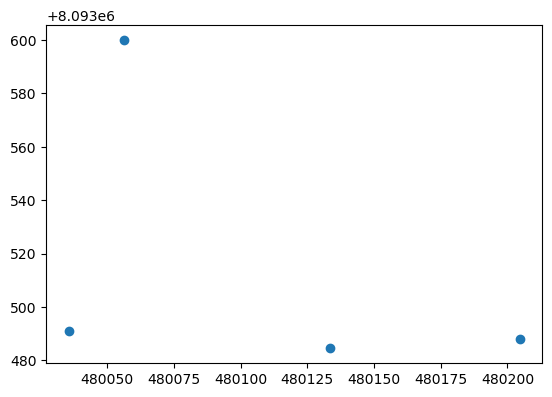

In [129]:
puntos_indi.plot()

In [130]:
# Asegurarse de que ambos GeoDataFrames tienen el mismo sistema de coordenadas (CRS)
if puntos_indi.crs != gdf_siembras.crs:
    print('Los CRS no son iguales')
    #gdf_siembras = gdf_siembras.to_crs(puntos_indi.crs)
else:
    print('Los CRS si son iguales')

Los CRS si son iguales


In [131]:
# Crear un GeoDataFrame vacío para almacenar los puntos que no intersectan con ningún polígono de siembras
puntos_indi_solicitado = puntos_indi[~puntos_indi.geometry.apply(lambda point: any(gdf_siembras.contains(point)))]

In [132]:
puntos_indi_solicitado

,unidad_03,unidad_04,os,dia,obs,procesado,geometry
12,1530,C.I.T.T.C.A,33,0,None,None,POINT (480204.614 8093487.788)
12,1530,C.I.T.T.C.A,33,0,None,None,POINT (480035.631 8093490.947)
12,1530,C.I.T.T.C.A,33,0,None,None,POINT (480133.547 8093484.630)
12,1530,C.I.T.T.C.A,33,0,None,None,POINT (480056.162 8093599.917)


In [133]:
# identifoca los lotes que se intersectan
gdf_lotes_cat = gpd.sjoin(gdf_cat, puntos_indi_solicitado, how='inner', predicate='intersects')
# filtra los lotes intersectados en la capa original
poligonos_intersect_cat = gdf_cat.loc[gdf_cat.index.isin(gdf_lotes_cat.index)]
# copy
poligonos_intersect_cat = poligonos_intersect_cat.copy()
poligonos_intersect_cat = poligonos_intersect_cat[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'soca', 'zona', 'geometry']]

In [134]:
# Cambiar el nombre de la columna 'old_name' a 'new_name'
poligonos_intersect_cat.rename(columns={'zona': 'inst'}, inplace=True)

In [135]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry
4773,299,C.I.T.T.C.A,1530,C.I.T.T.C.A.,C14.3,1.066949,2,124,"POLYGON ((480200.368 8093550.361, 480243.198 8..."
4774,299,C.I.T.T.C.A,1530,C.I.T.T.C.A.,C14.2,0.450754,1,124,"POLYGON ((480114.852 8093432.210, 480114.749 8..."
4775,299,C.I.T.T.C.A,1530,C.I.T.T.C.A.,C14.1,1.128854,1,124,"POLYGON ((480088.483 8093547.142, 480087.735 8..."
7593,299,C.I.T.T.C.A,1530,C.I.T.T.C.A.,C13.1,0.995924,0,124,"POLYGON ((480085.073 8093557.223, 480082.437 8..."


In [136]:
# CAMBIAR NOMBRE DATOS DE UNIDAD_03 Y UNDIAD_04 DE LOTES SOLICITADOS A LO INDICADO EN LOS PUNTOS
# Iterar sobre cada punto y encontrar el polígono que intersecta
for idx, point in puntos_indi_solicitado.iterrows():
    point_geom = point.geometry
    matching_polygons = poligonos_intersect_cat[poligonos_intersect_cat.intersects(point_geom)]
    
    # Actualizar los campos de los polígonos que intersectan con los valores del punto
    for poly_idx in matching_polygons.index:
        poligonos_intersect_cat.at[poly_idx, 'unidad_03'] = point['unidad_03']
        poligonos_intersect_cat.at[poly_idx, 'unidad_04'] = point['unidad_04']

In [137]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry
4773,299,C.I.T.T.C.A,1530,C.I.T.T.C.A,C14.3,1.066949,2,124,"POLYGON ((480200.368 8093550.361, 480243.198 8..."
4774,299,C.I.T.T.C.A,1530,C.I.T.T.C.A,C14.2,0.450754,1,124,"POLYGON ((480114.852 8093432.210, 480114.749 8..."
4775,299,C.I.T.T.C.A,1530,C.I.T.T.C.A,C14.1,1.128854,1,124,"POLYGON ((480088.483 8093547.142, 480087.735 8..."
7593,299,C.I.T.T.C.A,1530,C.I.T.T.C.A,C13.1,0.995924,0,124,"POLYGON ((480085.073 8093557.223, 480082.437 8..."


In [138]:
# agrega los campos faltantes
poligonos_intersect_cat['fecha_ini'] = ''
poligonos_intersect_cat['origen'] = 'SOLICITUD'
poligonos_intersect_cat['dias'] = 0
poligonos_intersect_cat['fecha'] = ''
poligonos_intersect_cat['os'] = ors

In [139]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,fecha_ini,origen,dias,fecha,os
4773,299,C.I.T.T.C.A,1530,C.I.T.T.C.A,C14.3,1.066949,2,124,"POLYGON ((480200.368 8093550.361, 480243.198 8...",,SOLICITUD,0,,33
4774,299,C.I.T.T.C.A,1530,C.I.T.T.C.A,C14.2,0.450754,1,124,"POLYGON ((480114.852 8093432.210, 480114.749 8...",,SOLICITUD,0,,33
4775,299,C.I.T.T.C.A,1530,C.I.T.T.C.A,C14.1,1.128854,1,124,"POLYGON ((480088.483 8093547.142, 480087.735 8...",,SOLICITUD,0,,33
7593,299,C.I.T.T.C.A,1530,C.I.T.T.C.A,C13.1,0.995924,0,124,"POLYGON ((480085.073 8093557.223, 480082.437 8...",,SOLICITUD,0,,33


In [140]:
# SELECCIONAR LOS LOTES DE SIEMBRAS
# identifoca los lotes que se intersectan
gdf_lotes_siem = gpd.sjoin(gdf_siembras, multipoint_gdf, how='inner', predicate='intersects')
# filtra los lotes intersectados en la capa original
poligonos_intersect_siem = gdf_siembras.loc[gdf_siembras.index.isin(gdf_lotes_siem.index)]
# copy
poligonos_intersect_siem = poligonos_intersect_siem.copy()
# agregar campo de semana_planificacion
poligonos_intersect_siem['os'] = ors

In [141]:
# crea el campo soca, y coloca 0 o 1 dependiendo del origen
poligonos_intersect_siem['soca'] = poligonos_intersect_siem['origen'].apply(lambda x: 1 if 'SIEMBRA 2023' in x else 0)

In [142]:
poligonos_intersect_siem = poligonos_intersect_siem[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area',
       'fecha_ini', 'origen', 'dias', 'fecha', 'prioridad', 'inst', 'geometry', 'os', 'soca']]

In [143]:
poligonos_intersect_siem

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,fecha_ini,origen,dias,fecha,prioridad,inst,geometry,os,soca


In [144]:
# Concatenar los DataFrames a lo largo de las filas (axis=0)
plan = pd.concat([poligonos_intersect_cat, poligonos_intersect_siem], axis=0)
# Si deseas restablecer el índice después de concatenar
plan.reset_index(drop=True, inplace=True)

<Axes: >

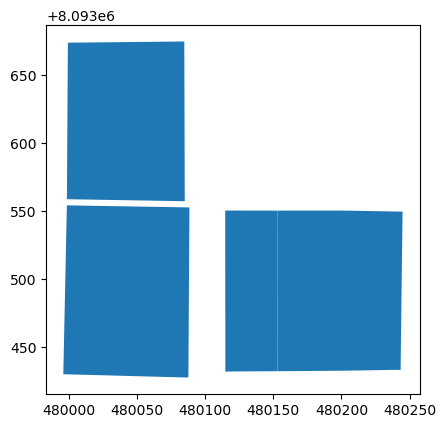

In [145]:
plan.plot()

In [146]:
plan['area'].sum()

3.6424800630239997

In [147]:
#RECALCULAR EL AREA
plan['area'] = plan.geometry.area / 10000

In [148]:
plan['area'].sum()

3.6424800630283363

In [149]:
# carga el shp de planificacion
gdf_plan = gpd.read_file(path_plan)

In [150]:
# determina el ultimo id
last_id = 0
if gdf_plan['id'].max() > 0:
    last_id = gdf_plan['id'].max()
else:
    last_id = 0

In [151]:
last_id

208

In [152]:
# Asignar valores incrementales a la columna 'id' empezando desde last_id + 1
plan['id'] = range(last_id + 1, last_id + 1 + len(plan))

In [153]:
plan

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,fecha_ini,origen,dias,fecha,os,prioridad,id
0,299,C.I.T.T.C.A,1530,C.I.T.T.C.A,C14.3,1.066949,2,124,"POLYGON ((480200.368 8093550.361, 480243.198 8...",,SOLICITUD,0.0,,33,NaN,209
1,299,C.I.T.T.C.A,1530,C.I.T.T.C.A,C14.2,0.450754,1,124,"POLYGON ((480114.852 8093432.210, 480114.749 8...",,SOLICITUD,0.0,,33,NaN,210
2,299,C.I.T.T.C.A,1530,C.I.T.T.C.A,C14.1,1.128854,1,124,"POLYGON ((480088.483 8093547.142, 480087.735 8...",,SOLICITUD,0.0,,33,NaN,211
3,299,C.I.T.T.C.A,1530,C.I.T.T.C.A,C13.1,0.995924,0,124,"POLYGON ((480085.073 8093557.223, 480082.437 8...",,SOLICITUD,0.0,,33,NaN,212


In [154]:
len(plan)

4

In [155]:
# union de los dos gdf
gdf_pla_gral = pd.concat([gdf_plan, plan], ignore_index=True)

In [156]:
gdf_pla_gral['area'].sum()

1899.6177401442128

In [157]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['dias'] = gdf_pla_gral['dias'].astype(int)
#gdf_pla_gral['prioridad'] = gdf_pla_gral['prioridad'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)

In [158]:
# exportar los datos en nuevo shp
gdf_pla_gral.to_file(path_plan)

In [159]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,fecha_ini,origen,dias,fecha,prioridad,os,soca,id,inst,telefono_1,telefono_2,telefono_3,geometry
0,47,SANTA MARTHA,40149,PAZ REA JOSE ERNESTO,A7,10.696703,21/5/2024,SIEMBRA 2023,37,2024-05-21,1.0,26,1,1,69,NaN,NaN,None,"POLYGON ((488616.298 8103763.516, 488519.488 8..."
1,187,MATIAS--HABBAUER,5421,HUBBAUER HOYOS ENRIQUE,L7.2,1.835936,2024-04-15,SIEMBRA 2024,73,2024-04-15,6.0,26,0,2,62,NaN,NaN,None,"POLYGON ((473330.370 8101634.734, 473440.011 8..."
2,187,MATIAS--HABBAUER,5421,HUBBAUER HOYOS ENRIQUE,L6,1.960231,2024-04-15,SIEMBRA 2024,73,2024-04-15,6.0,26,0,3,62,NaN,NaN,None,"POLYGON ((473242.172 8101427.289, 473148.580 8..."
3,187,MATIAS--HABBAUER,5421,HUBBAUER HOYOS ENRIQUE,L9.1,3.607907,2024-04-16,SIEMBRA 2024,72,2024-04-16,6.0,26,0,4,62,NaN,NaN,None,"POLYGON ((473286.579 8101086.503, 473265.875 8..."
4,2123,LAS CHACRAS PORTACHUELO,13132,ZUMARAN MENACHO JORGE,L1.6,0.386826,2024-04-22,SIEMBRA 2024,66,2024-04-22,10.0,26,0,5,50,NaN,NaN,None,"POLYGON ((455236.898 8084312.120, 455248.807 8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,400,TOTAISAL--AGUILERA AÑEZ,446,AGUILERA ANEZ JHONNY,L8,11.214586,2024-05-06,SIEMBRA 2024,52,2024-05-06,8.0,34,0,208,66,NaN,NaN,None,"POLYGON ((499155.935 8084036.495, 499057.708 8..."
207,299,C.I.T.T.C.A,1530,C.I.T.T.C.A,C14.3,1.066949,,SOLICITUD,0,,NaN,33,2,209,124,NaN,NaN,NaN,"POLYGON ((480200.368 8093550.361, 480243.198 8..."
208,299,C.I.T.T.C.A,1530,C.I.T.T.C.A,C14.2,0.450754,,SOLICITUD,0,,NaN,33,1,210,124,NaN,NaN,NaN,"POLYGON ((480114.852 8093432.210, 480114.749 8..."
209,299,C.I.T.T.C.A,1530,C.I.T.T.C.A,C14.1,1.128854,,SOLICITUD,0,,NaN,33,1,211,124,NaN,NaN,NaN,"POLYGON ((480088.483 8093547.142, 480087.735 8..."


# CARGAR PLANIFICACION A AMIGOCLOUD

In [160]:
def convertir_a_multipolygon(geometry):
    if isinstance(geometry, Polygon):
        return MultiPolygon([geometry])
    return geometry

def convertir_a_wkb(polygon):
    wkb_data = wkb.dumps(polygon, hex=True)
    return wkb_data

In [161]:
# repreyectar a WGS84
gdf_pla_gral = plan.to_crs(epsg=4326)
# convertir poligonos a multipoligonos
gdf_pla_gral['geometry'] = gdf_pla_gral['geometry'].apply(convertir_a_multipolygon)

In [162]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['dias'] = gdf_pla_gral['dias'].astype(int)
#gdf_pla_gral['prioridad'] = gdf_pla_gral['prioridad'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)

In [163]:
len(gdf_pla_gral)

4

In [164]:
# recorrer el gdf de lotes y cargarlo a amigocloud
id_proyecto = f'https://app.amigocloud.com/api/v1/projects/33457/sql'
for index, row in gdf_pla_gral.iterrows():
    wkb_hex = convertir_a_wkb(row['geometry'])
    insert_sql = f"""
    INSERT INTO dataset_345601 (id, unidad_01, unidad_02, unidad_03, unidad_04, unidad_05, area, origen, dias, os, geometry)
    VALUES ({row['id']}, {row['unidad_01']}, '{row['unidad_02']}', {row['unidad_03']}, '{row['unidad_04']}', '{row['unidad_05']}', {row['area']}, '{row['origen']}', '{row['dias']}', '{row['os']}', ST_SetSRID(ST_GeomFromWKB('\\x{wkb_hex}'), 4326));
    """
    query_sql = {'query': insert_sql}
    resultado_post = amigocloud.post(id_proyecto, query_sql)

# CREAR KMLS DE PLANIFICACION

In [165]:
gdf_plan = gpd.read_file(path_plan)

In [166]:
gdf_plan_sem = gdf_plan[gdf_plan['os'] == ors]
gdf_plan_sem['area'].sum()

3.642480063028336

In [167]:
lista_cods = list(set(gdf_plan_sem['unidad_01']))

In [168]:
lista_cods

[299]

In [169]:
for i in lista_cods:
    prop = gdf_plan_sem[gdf_plan_sem['unidad_01'] == i]
    prop_wgs = prop.to_crs(epsg=4326)
    output_folder = path_kml + '\\' + str(i)
    print(output_folder)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Recorrer el GeoDataFrame
    for idx, row in prop_wgs.iterrows():
        # Crear un nuevo documento KML
        kml_doc = simplekml.Kml()
        # Obtener el polígono y el nombre
        polygon = row['geometry']
        name = row['unidad_05']
        # Convertir el polígono en una lista de coordenadas
        coords = [(x, y) for x, y in zip(*polygon.exterior.xy)]    
        # Añadir el polígono al documento KML
        pol = kml_doc.newpolygon(name=name, outerboundaryis=coords)
        # Guardar el archivo KML
        file_name = f"{name}.kml"
        output_path = os.path.join(output_folder, file_name)
        kml_doc.save(output_path)

G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\KML_PLAN\299


# CARGAR XLSX

In [170]:
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from datetime import datetime

In [171]:
# Cargar el archivo Excel
sheet_name = 'DATA'
table_name = 'tbl_data'

In [172]:
excel_data = pd.read_excel(path_xlsx_parte)

In [173]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,fecha_ini,origen,dias,fecha,os,prioridad,id
0,299,C.I.T.T.C.A,1530,C.I.T.T.C.A,C14.3,1.066949,2,124,"MULTIPOLYGON (((-63.18625 -17.24303, -63.18585...",,SOLICITUD,0,,33,NaN,209
1,299,C.I.T.T.C.A,1530,C.I.T.T.C.A,C14.2,0.450754,1,124,"MULTIPOLYGON (((-63.18706 -17.24409, -63.18706...",,SOLICITUD,0,,33,NaN,210
2,299,C.I.T.T.C.A,1530,C.I.T.T.C.A,C14.1,1.128854,1,124,"MULTIPOLYGON (((-63.18731 -17.24305, -63.18731...",,SOLICITUD,0,,33,NaN,211
3,299,C.I.T.T.C.A,1530,C.I.T.T.C.A,C13.1,0.995924,0,124,"MULTIPOLYGON (((-63.18734 -17.24296, -63.18736...",,SOLICITUD,0,,33,NaN,212


In [174]:
list(gdf_pla_gral['unidad_01'])

[299, 299, 299, 299]

In [175]:
new_data = {
    'INSTITUCION':list(gdf_pla_gral['inst']), 
    'COD CANERO': list(gdf_pla_gral['unidad_03']),
    'NOMBRE CANERO': list(gdf_pla_gral['unidad_04']),
    'COD PROPIEDAD': list(gdf_pla_gral['unidad_01']),
    'NOMBRE PROPIEDAD': list(gdf_pla_gral['unidad_02']),
    'LOTE': list(gdf_pla_gral['unidad_05']),
    'HECTAREA': list(gdf_pla_gral['area']),
    'CICLO': list(gdf_pla_gral['soca']),
    'FINANCIADO': list(gdf_pla_gral['origen']),
    'ID': list(gdf_pla_gral['id']),
    'OS': list(gdf_pla_gral['os'])
}

new_df = pd.DataFrame(new_data)

In [176]:
new_df['PRODUCTO'] = 'TRICHOGRAMMA'
new_df['DOSIS'] = '6ml'

In [177]:
new_df

,INSTITUCION,COD CANERO,NOMBRE CANERO,COD PROPIEDAD,NOMBRE PROPIEDAD,LOTE,HECTAREA,CICLO,FINANCIADO,ID,OS,PRODUCTO,DOSIS
0,124,1530,C.I.T.T.C.A,299,C.I.T.T.C.A,C14.3,1.066949,2,SOLICITUD,209,33,TRICHOGRAMMA,6ml
1,124,1530,C.I.T.T.C.A,299,C.I.T.T.C.A,C14.2,0.450754,1,SOLICITUD,210,33,TRICHOGRAMMA,6ml
2,124,1530,C.I.T.T.C.A,299,C.I.T.T.C.A,C14.1,1.128854,1,SOLICITUD,211,33,TRICHOGRAMMA,6ml
3,124,1530,C.I.T.T.C.A,299,C.I.T.T.C.A,C13.1,0.995924,0,SOLICITUD,212,33,TRICHOGRAMMA,6ml


In [178]:
final_data = pd.concat([excel_data, new_df], ignore_index=True)

In [179]:
final_data.to_excel(path_xlsx_parte, index=False)